# DoubleML for Flexible Covariate Adjustment in Regression Discontinuity Designs (RDD)

This notebook demonstrates how to use RDD designs within ``DoubleML``. Our implementation, ``RDFlex``, is based on the paper _"Flexible Covariate Adjustments in Regression Discontinuity Designs"_ by [Noack, Olma and Rothe (2024)](https://arxiv.org/abs/2107.07942). 

In regression discontinuity designs (RDD), treatment assignment is determined by a continuous running variable $S$ (or "score") crossing a known threshold $c$ (or "cutoff"). We aim to estimate the average treatment effect locally at the cutoff:

$$\tau_{0} = \mathbb{E}[Y_i(1)-Y_i(0)\mid S_i = c].$$

We therefore assume, that individuals are not able to manipulate their score in the neighborhood of the cutoff and that there is a discontinuity in the outcome that can be explained solely by the score.

In [20]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objs as go
from statsmodels.nonparametric.kernel_regression import KernelReg

from lightgbm import LGBMRegressor, LGBMClassifier

from rdrobust import rdrobust

import doubleml as dml
from doubleml.rdd import RDFlex
from doubleml.rdd.datasets import make_simple_rdd_data

## Sharp RDD

In the sharp design, the treatment assignment is deterministic given the score. Namely, all the individuals with a score higher than the cutoff, receive the treatment $$D_i = \mathbb{I}[S_i \geq c].$$

### Generate Data

The function ``make_simple_rdd_data()`` can be used to generate data of a rather standard RDD setting. If we set ``fuzzy = False``, the generated data follows a sharp RDD. We also generate covariates $X$ that can be used to adjust the estimation at a later stage.
By default, the cutoff is normalized to ``c = 0``. The true RDD effect can be controlled by ``tau`` and is set to a value of $2.0$ in this example.

In [21]:
np.random.seed(1234)

true_tau = 2.0
data_dict = make_simple_rdd_data(n_obs=1000, fuzzy=False, tau=true_tau)

cov_names = ['x' + str(i) for i in range(data_dict['X'].shape[1])]
df = pd.DataFrame(
    np.column_stack((data_dict['Y'], data_dict['D'], data_dict['score'], data_dict['X'])),
    columns=['y', 'd', 'score'] + cov_names,
)
df.head()

,y,d,score,x0,x1,x2
0,1.563067,1.0,0.471435,-0.198503,-0.193849,-0.493426
1,1.348622,0.0,-1.190976,0.013677,-0.630880,-0.885832
2,2.265929,1.0,1.432707,-0.266147,0.439675,-0.051651
3,7.477357,0.0,-0.312652,0.845241,-0.659755,0.436764
4,13.185130,0.0,-0.720589,0.739595,-0.741380,0.948112


Comparing the observed outcomes, we can clearly see a discontinuity at the cutoff value of $c = 0$.

In [22]:
fig = px.scatter(
    x=df['score'],
    y=df['y'],
    color=df['d'].astype(bool),
    labels={
        "x": "Score",   
        "y": "Outcome",
        "color": "Treatment"
    },
    title="Scatter Plot of Outcome vs. Score by Treatment Status"
)

fig.update_layout(
    xaxis_title="Score",
    yaxis_title="Outcome"
)
fig.show()

C:\Users\BAQ7040\AppData\Roaming\Python\Python311\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### RDD without Adjustment

The standard RDD estimator for the sharp design takes the form 

$$\hat{\tau}_{\text{base}}(h) = \sum_{i=1}^n w_i(h)Y_i,$$

where the $w_i(h)$ are local linear regression weights that depend on the data through the realizations of the running variable only and $h > 0$ is a bandwidth.

The packages ``rdrobust`` implements this estimation.

In [23]:
rdrobust_sharp_noadj = rdrobust(y=df['y'], x=df['score'], fuzzy=df['d'], c=0.0)
rdrobust_sharp_noadj

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           493        507
Number of Unique Obs.            493        507
Number of Effective Obs.         291        299
Bandwidth Estimation            0.78       0.78
Bandwidth Bias                 1.282      1.282
rho (h/b)                      0.608      0.608

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       2.407    0.634    3.795   1.475e-04      [1.164, 3.65]
Robust                 -        -    3.122   1.796e-03     [0.869, 3.802]


### RDD with Linear Adjustment

The linearly adjusted RDD estimator for the sharp design takes the form 

$$\hat{\tau}_{lin}(h) = \sum_{i=1}^n w_i(h)(Y_i-X_i^T\hat{\gamma}_h)$$

where $w_i(h)$ are local linear regression weights that depend on the data through the realizations of the running variable $S_i$ only and $h>0$ is a bandwidth. $\hat{\gamma}_h$ is a minimizer from the regression

$$\underset{\beta,\gamma}{\mathrm{arg\,min}} \, \sum K_h(S_i) (Y_i - Q_i^\top\beta- X_i^{\top}\gamma )^2.$$

with $Q_i =(D_i, S_i, D_i S_i,1)^T$ (for more details, see our [User Guide](https://docs.doubleml.org/stable/guide/models.html)), $K_h(v)=K(v/h)/h$ with $K(\cdot)$ a kernel function.

The packages ``rdrobust`` implements this estimation with a linear adjustment.

In [24]:
rdrobust_sharp = rdrobust(y=df['y'], x=df['score'], fuzzy=df['d'], covs=df[cov_names], c=0.0)
rdrobust_sharp

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           493        507
Number of Unique Obs.            493        507
Number of Effective Obs.         281        285
Bandwidth Estimation           0.732      0.732
Bandwidth Bias                  1.22       1.22
rho (h/b)                        0.6        0.6

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       2.207    0.433    5.099   3.416e-07     [1.359, 3.056]
Robust                 -        -    4.311   1.629e-05     [1.189, 3.172]


### RDD with flexible adjustment

[Noack, Olma and Rothe (2024)](https://arxiv.org/abs/2107.07942) propose an estimator that reduces the variance of the above esimator, using a flexible adjustment of the outcome by machine learning. For more details, see our [User Guide](https://docs.doubleml.org/stable/guide/models.html). The estimator here takes the form 

$$\hat{\tau}_{\text{RDFlex}}(h;\eta) = \sum_{i=1}^n w_i(h)M_i(\eta),\quad M_i(\eta) = Y_i - \eta(X_i),$$

with $\eta(\cdot)$ being potentially nonlinear adjustment functions.

We initialize a `DoubleMLData` object using the usual package syntax:

 - `y_col` refers to the observed outcome, on which we want to estimate the effect at the cutoff
 - `s_col` refers to the score
 - `x_cols` refers to the covariates to be adjusted for
 - `d_cols` is an indicator whether an observation is treated or not. In the sharp design, this should be identical to an indicator whether an observation is left or right of the cutoff ($D_i = \mathbb{I}[S_i \geq c]$)

In [25]:
dml_data_sharp = dml.DoubleMLData(df, y_col='y', d_cols='d', x_cols=cov_names, s_col='score')

The ``RDFlex`` object is intialized with only one learner, that adjusts the outcome based on the covariates.

In [26]:
ml_g = LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=-1)

rdflex_sharp = RDFlex(dml_data_sharp,
                      ml_g,
                      cutoff=0,
                      fuzzy=False,
                      n_folds=5,
                      n_rep=1)
rdflex_sharp.fit(n_iterations=2)

print(rdflex_sharp)

Method             Coef.     S.E.     t-stat       P>|t|           95% CI
-------------------------------------------------------------------------
Conventional      2.014     0.103     19.494   1.231e-84  [1.812, 2.217]
Robust                 -        -     16.872   7.173e-64  [1.779, 2.247]


It is visible that the flexible adjustment decreases the standard error in the estimation and therefore provides tighter confidence intervals. For coverage simulations, see the [DoubleML Coverage Repository](https://docs.doubleml.org/doubleml-coverage/dev/rdd/rdd.html).

`RDFlex` uses a iterative fitting approach to determine a preliminary bandwidth selections for the local adjustments. The default number of iterations is `n_iterations=2`, according to [Noack, Olma and Rothe (2024)](https://arxiv.org/abs/2107.07942).

## Fuzzy RDD

In the fuzzy RDDs, the treatment assignment is still deterministic given the score $\left(T_i = \mathbb{I}[S_i \geq c]\right)$.
However, in the neighborhood of the cutoff, there is a probability of non-complianc. Thus, the treatment received might differ from the assigned one $(D_i \neq T_i)$ for some units. These observations cause the probability jump of treatment at the cutoff to be smaller than 1 but larger than 0. In other words, around the cutoff there can be treatment randomization on both sides.

The parameter of interest in the Fuzzy RDD is the average treatment effect at the cutoff, for all individuals that comply with the assignment:

$$\theta_{0} = \mathbb{E}[Y_i(1, 1)-Y_i(0, 0)\mid S_i = c, \{i\in \text{compliers}\}]$$

### Generate Data

The function ``make_simple_rdd_data()`` with ``fuzzy = True`` generates basic data for the fuzzy case. The cutoff is still set to $c = 0$ and we set the true effect to be ``tau = 2.0`` again.

In [27]:
np.random.seed(1234)

data_dict = make_simple_rdd_data(n_obs=1000, fuzzy=True, tau=true_tau)

cov_names = ['x' + str(i) for i in range(data_dict['X'].shape[1])]
df = pd.DataFrame(
    np.column_stack((data_dict['Y'], data_dict['D'], data_dict['score'], data_dict['X'])),
    columns=['y', 'd', 'score'] + cov_names,
)
df.head()

,y,d,score,x0,x1,x2
0,-0.183553,0.0,0.471435,-0.198503,-0.193849,-0.493426
1,1.348622,0.0,-1.190976,0.013677,-0.630880,-0.885832
2,2.265929,1.0,1.432707,-0.266147,0.439675,-0.051651
3,9.694561,1.0,-0.312652,0.845241,-0.659755,0.436764
4,15.001403,1.0,-0.720589,0.739595,-0.741380,0.948112


Comparing the observed outcomes, the discontinuity is less pronounced than in the sharp case. We see some degree of randomization left and right of the cutoff.

In [28]:
fig = px.scatter(
    x=df['score'],
    y=df['y'],
    color=df['d'].astype(bool),
    labels={
        "x": "Score",   
        "y": "Outcome",
        "color": "Treatment"
    },
    title="Scatter Plot of Outcome vs. Score by Treatment Status"
)

fig.update_layout(
    xaxis_title="Score",
    yaxis_title="Outcome"
)
fig.show()

C:\Users\BAQ7040\AppData\Roaming\Python\Python311\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### RDD without Adjustment

The standard RDD estimator for the fuzzy design takes the form 

$$\hat{\theta}_{base}(h) = \frac{\hat{\tau}_{\text{Y}, base}(h)}{\hat{\tau}_{\text{D}, base}(h)} = \frac{\sum_{i=1}^n w_i(h)Y_i}{\sum_{i=1}^n w_i(h)D_i}$$

The packages ``rdrobust`` implements this estimation.

In [29]:
rdrobust_fuzzy_noadj = rdrobust(y=df['y'], x=df['score'], fuzzy=df['d'], c=0.0)
rdrobust_fuzzy_noadj

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           493        507
Number of Unique Obs.            493        507
Number of Effective Obs.         213        224
Bandwidth Estimation           0.542      0.542
Bandwidth Bias                 0.864      0.864
rho (h/b)                      0.628      0.628

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional        4.64    3.052     1.52   1.285e-01   [-1.343, 10.622]
Robust                 -        -    1.414   1.575e-01   [-1.952, 12.054]


### RDD with Linear Adjustment

The linearly adjusted RDD estimator for the fuzzy design takes the form 

$$\hat{\theta}_{lin}(h) = \frac{\hat{\tau}_{\text{Y}, lin}(h)}{\hat{\tau}_{\text{D}, lin}(h)} = \frac{\sum_{i=1}^n w_i(h)(Y_i-X_i^T\hat{\gamma}_{Y, h})}{\sum_{i=1}^n w_i(h)(D_i-X_i^T\hat{\gamma}_{D, h})}$$

Under similar assumptions as in the sharp case and that there are no *Defiers* (= individuals that would always pick the opposite treatment of their assigned one), this effect estimates the average treatment effect at the cutoff. The package ``rdrobust`` implements this estimation with a linear adjustment.

In [30]:
rdrobust_fuzzy = rdrobust(y=df['y'], x=df['score'], fuzzy=df['d'], covs=df[cov_names], c=0.0)
rdrobust_fuzzy

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           493        507
Number of Unique Obs.            493        507
Number of Effective Obs.         211        223
Bandwidth Estimation            0.54       0.54
Bandwidth Bias                  0.88       0.88
rho (h/b)                      0.614      0.614

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       2.802    2.326    1.205   2.283e-01    [-1.757, 7.361]
Robust                 -        -    1.097   2.728e-01    [-2.367, 8.381]


The fuzzy design usually has much larger standard errors than the sharp design, as the jump in treatment probability adds further estimation uncertainty.

### RDD with flexible adjustment

[Noack, Olma and Rothe (2024)](https://arxiv.org/abs/2107.07942) propose an estimator that reduces the variance of the above esimator, using a flexible adjustment of the outcome by ML. For more details, see our [User Guide](https://docs.doubleml.org/stable/guide/models.html). The estimator here takes the form 

$$\hat{\theta}_{\text{RDFlex}}(h; \eta) = \frac{\sum_{i=1}^n w_i(h)(Y_i - \hat{\eta}_Y(X_i))}{\sum_{i=1}^n w_i(h)(D_i - \hat{\eta}_D(X_i))},$$


with $\eta_Y(\cdot), \eta_D(\cdot)$ being potentially nonlinear adjustment functions.

We initialize a `DoubleMLData` object using the usual package syntax:

 - `y_col` refers to the observed outcome, on which we want to estimate the effect at the cutoff
 - `s_col` refers to the score
 - `x_cols` refers to the covariates to be adjusted for
 - `d_cols` is an indicator whether an observation is treated or not. In the fuzzy design, this should __not__ be identical to an indicator whether an observation is left or right of the cutoff ($D_i \neq \mathbb{I}[S_i \geq c]$)

In [31]:
dml_data_fuzzy = dml.DoubleMLData(df, y_col='y', d_cols='d', x_cols=cov_names, s_col='score')

This time, we also have to specify a classifier that adjusts the treatment assignment probabilities.

In [32]:
ml_g = LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=-1)
ml_m = LGBMClassifier(n_estimators=500, learning_rate=0.01, verbose=-1)

rdflex_fuzzy = RDFlex(dml_data_fuzzy,
                      ml_g,
                      ml_m,
                      cutoff=0,
                      fuzzy=True,
                      n_folds=5,
                      n_rep=1)
rdflex_fuzzy.fit(n_iterations=2)

print(rdflex_fuzzy)

Method             Coef.     S.E.     t-stat       P>|t|           95% CI
-------------------------------------------------------------------------
Conventional      0.979     0.726     1.348    1.777e-01  [-0.445, 2.403]
Robust                 -        -     0.994    3.201e-01  [-0.831, 2.541]


Also for the fuzzy case, we observe a significant decrease in estimation standard error.

## Advanced: Global and Local Learners, Stacked Ensembles

By default, ``RDFlex`` fits ML methods using kernel weights, resulting in a "local" fit around the cutoff. If the adjustment should also include "global" information from the full support of $S$ available in the data, the use of a the ``GlobalLearner`` wrapper is recommended.

The ``GlobalLearner`` allows to ignore the weights and fit the ML method on the full support of the data, even if weights are provided.

The learners can also be stacked. All learners have to support the `sample_weight` in their `fit` method. By stacking and using local and global learners, it is possible to further tune the estimation and potentially reduce standard errors even further.

In [33]:
from doubleml.utils import GlobalRegressor, GlobalClassifier

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import StackingClassifier, StackingRegressor

In [34]:
reg_estimators = [
    ('lr local', LinearRegression()),
    ('rf local', RandomForestRegressor()),
    ('lr global', GlobalRegressor(base_estimator=LinearRegression())),
    ('rf global', GlobalRegressor(base_estimator=RandomForestRegressor()))
]

class_estimators = [
    ('lr local', LogisticRegression()),
    ('rf local', RandomForestClassifier()),
    ('lr global', GlobalClassifier(base_estimator=LogisticRegression())),
    ('rf global', GlobalClassifier(base_estimator=RandomForestClassifier()))
]

ml_g = StackingRegressor(
    estimators=reg_estimators,
    final_estimator=LinearRegression(),
)

ml_m = StackingClassifier(
    estimators=class_estimators,
    final_estimator=LogisticRegression(),
)

We first repeat the estimation of the sharp design and observe an even smaller standard error.

In [35]:
rdflex_sharp_stack = RDFlex(dml_data_sharp,
                            ml_g,
                            fuzzy=False,
                            n_folds=5,
                            n_rep=1)
rdflex_sharp_stack.fit(n_iterations=2)

print(rdflex_sharp_stack)

Method             Coef.     S.E.     t-stat       P>|t|           95% CI
-------------------------------------------------------------------------
Conventional      1.876     0.101     18.635   1.676e-77  [1.679, 2.073]
Robust                 -        -     15.964   2.260e-57  [1.613, 2.064]


The same applies for the fuzzy case.

In [36]:
rdflex_fuzzy_stack = RDFlex(dml_data_fuzzy,
                            ml_g,
                            ml_m,
                            fuzzy=True,
                            n_folds=5,
                            n_rep=1)
rdflex_fuzzy_stack.fit(n_iterations=2)

print(rdflex_fuzzy_stack)

Method             Coef.     S.E.     t-stat       P>|t|           95% CI
-------------------------------------------------------------------------
Conventional      1.760     0.612     2.878    4.004e-03  [0.561, 2.959]
Robust                 -        -     2.697    7.004e-03  [0.524, 3.313]


For a conclusion, we look at a visualization of the estimated coefficient and the confidence intervals. We see that by using the flexible adjustment, it is possible to shrink confidence bands.

In [37]:
df_sharp = pd.DataFrame({"coef": [rdrobust_sharp_noadj.coef.values[0][0], rdrobust_sharp.coef.values[0][0], rdflex_sharp.coef[0], rdflex_sharp_stack.coef[0]],
                         "CI lower": [rdrobust_sharp_noadj.ci.values[0][0], rdrobust_sharp.ci.values[0][0], rdflex_sharp.confint().values[0][0], rdflex_sharp_stack.confint().values[0][0]],
                         "CI upper": [rdrobust_sharp_noadj.ci.values[0][1], rdrobust_sharp.ci.values[0][1], rdflex_sharp.confint().values[0][1], rdflex_sharp_stack.confint().values[0][1]],
                         "method": ["No Adj.", "Linear Adj.", "Flexible Adj.", "Flexible Adj. (Stacked)"]})
df_fuzzy = pd.DataFrame({"coef": [rdrobust_fuzzy_noadj.coef.values[0][0], rdrobust_fuzzy.coef.values[0][0], rdflex_fuzzy.coef[0], rdflex_fuzzy_stack.coef[0]],
                         "CI lower": [rdrobust_fuzzy_noadj.ci.values[0][0], rdrobust_fuzzy.ci.values[0][0], rdflex_fuzzy.confint().values[0][0], rdflex_fuzzy_stack.confint().values[0][0]],
                         "CI upper": [rdrobust_fuzzy_noadj.ci.values[0][1], rdrobust_fuzzy.ci.values[0][1], rdflex_fuzzy.confint().values[0][1], rdflex_fuzzy_stack.confint().values[0][1]],
                         "method": ["No Adj.", "Linear Adj.", "Flexible Adj.", "Flexible Adj. (Stacked)"]})

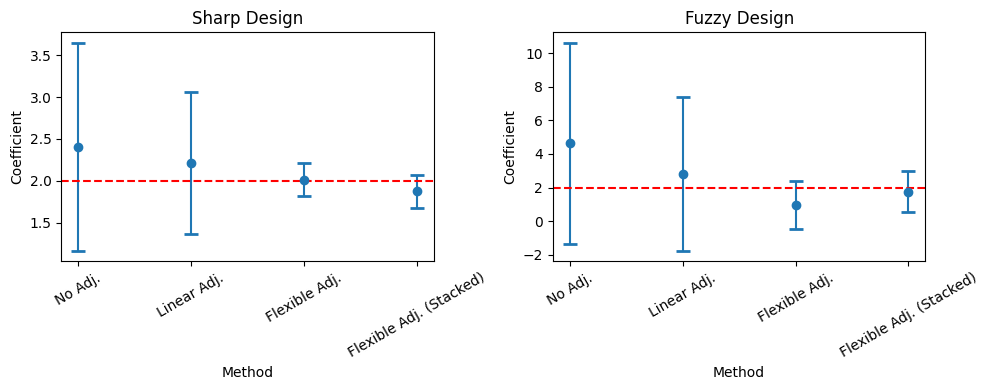

In [38]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].errorbar(
    df_sharp['method'],
    df_sharp['coef'],
    yerr=(df_sharp['coef'] - df_sharp['CI lower'], df_sharp['CI upper'] - df_sharp['coef']),
    fmt='o',
    capsize=5,
    capthick=2
)
axes[0].set_title('Sharp Design')
axes[0].set_ylabel('Coefficient')
axes[0].set_xlabel('Method')
axes[0].axhline(true_tau, linestyle="--", color="r")
axes[0].tick_params(axis='x', rotation=30)

axes[1].errorbar(
    df_fuzzy['method'],
    df_fuzzy['coef'],
    yerr=(df_fuzzy['coef'] - df_fuzzy['CI lower'], df_fuzzy['CI upper'] - df_fuzzy['coef']),
    fmt='o',
    capsize=5,
    capthick=2
)
axes[1].set_title('Fuzzy Design')
axes[1].set_ylabel('Coefficient')  
axes[1].set_xlabel('Method')
axes[1].axhline(true_tau, linestyle="--", color="r")
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()